# Data Science - Poster Workshop
# How can we analyze data in order to discover new insights that are eventually in?

We are using the Yeast dataset from:     

    Kenta Nakai
    Institue of Molecular and Cellular Biology
	Osaka, University
	1-3 Yamada-oka, Suita 565 Japan
    nakai@imcb.osaka-u.ac.jp
    http://www.imcb.osaka-u.ac.jp/nakai/psort.html
    Donor: Paul Horton (paulh@cs.berkeley.edu)
    Date:  September, 1996
    See also: ecoli database

This dataset is available here in the [UCI Archive](https://archive.ics.uci.edu/dataset/110/yeast)

For this data science poster workshop we will be seeing different ways of classifying the data

### Here are the poster workshop specifications

- The pw is organised at the end of the semester. The pw is based on the presentation of project.
- A student can participate individually or as a member of a group of up to 3 students and thus take part in the project.
- A project is defined as a performance in the sense of data science on a data set that is provided. Possibly, 2 or 3 data sets will be presented and each group can choose 1 of them.
- The project work consists of demonstrating an aspect of the course using the selected dataset. The terminology must be used.
- The PW is divided into two parts: 

    - Part 1 is an "appetiser" presentation in which the most important aspects of the project are presented (5 minutes). The aim is to promote own work and convince examiners to come and get more information
    - In Part 2, each student/group hangs a poster on the wall and explains the work to the examiners.  

In [34]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np

In [35]:
data = pd.read_csv("yeast/yeast.data", header=None, sep='\s+', engine='python')

data.columns = ["Sequence_Name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "localization_site"]

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sequence_Name      1484 non-null   object 
 1   mcg                1484 non-null   float64
 2   gvh                1484 non-null   float64
 3   alm                1484 non-null   float64
 4   mit                1484 non-null   float64
 5   erl                1484 non-null   float64
 6   pox                1484 non-null   float64
 7   vac                1484 non-null   float64
 8   nuc                1484 non-null   float64
 9   localization_site  1484 non-null   object 
dtypes: float64(8), object(2)
memory usage: 116.1+ KB


In [36]:
data.head()

,Sequence_Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,localization_site
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


The goal of this poster is to predict our target "localization_site" based on the 8 features given.

We will perform classification on using multiple different models and evaluate the performance of each model based on its accuracy and precision.

Finaly we will look at overall insights we can draw from this analysis.

localization_site
CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: count, dtype: int64


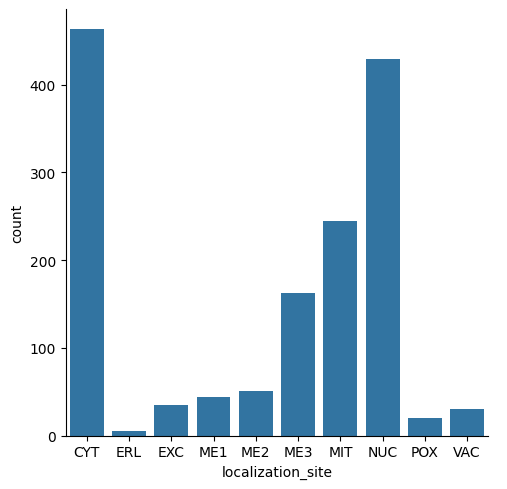

In [37]:
# The number of different occurences for each localization sites
print(data['localization_site'].value_counts())

# Setup localization_site as a category
data["localization_site"] = data["localization_site"].astype('category')

# Plots the number of different occurences for each localization sites
sns.catplot(data, x="localization_site", kind="count")

In [38]:
from sklearn.preprocessing import OneHotEncoder

# One hot encoding the localization_site column
encoder = OneHotEncoder()
encoded_results = encoder.fit_transform(data).toarray()

# df_encoded = pd.get_dummies(df, columns=["localization_site"], drop_first=True)

# df_encoded.info()

# df_encoded.head()

[Source](https://stackabuse.com/classification-in-python-with-scikit-learn-and-pandas/)

In [39]:
# Basic Logistic Regression Model / Random Forest Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = data.iloc[:, 1:-1]
y = data.iloc[:, -1]

# Encoding the target variable into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)

# Random Forest Model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
forest_predictions = random_forest_model.predict(X_test)

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
forest_accuracy = accuracy_score(y_test, forest_predictions)

print("Logistic Regression Accuracy:", logistic_accuracy)
print("Random Forest Accuracy:", forest_accuracy)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, logistic_predictions, labels=label_encoder.transform(label_encoder.classes_), target_names=label_encoder.classes_))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, forest_predictions, labels=label_encoder.transform(label_encoder.classes_), target_names=label_encoder.classes_))

Logistic Regression Accuracy: 0.5858585858585859
Random Forest Accuracy: 0.6262626262626263

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         CYT       0.51      0.70      0.59        96
         ERL       0.00      0.00      0.00         0
         EXC       0.00      0.00      0.00         8
         ME1       0.62      0.62      0.62         8
         ME2       0.00      0.00      0.00         6
         ME3       0.93      0.74      0.82        34
         MIT       0.67      0.56      0.61        52
         NUC       0.54      0.54      0.54        85
         POX       1.00      1.00      1.00         2
         VAC       0.00      0.00      0.00         6

   micro avg       0.59      0.59      0.59       297
   macro avg       0.43      0.42      0.42       297
weighted avg       0.57      0.59      0.57       297


Random Forest Classification Report:
              precision    recall  f1-score   support

         CYT

/home/minihic/repos/data-science-2024-poster/.conda-ds1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/minihic/repos/data-science-2024-poster/.conda-ds1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/minihic/repos/data-science-2024-poster/.conda-ds1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control thi

In [40]:
from sklearn.model_selection import cross_val_score, KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

logistic_model = LogisticRegression(max_iter=1000)
logistic_cv_scores = cross_val_score(logistic_model, X_train, y_train, cv=kfold, scoring='accuracy')

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
forest_cv_scores = cross_val_score(random_forest_model, X_train, y_train, cv=kfold, scoring='accuracy')

print("Logistic Regression Cross-Validation Accuracy Scores:", logistic_cv_scores)
print("Average Logistic Regression CV Accuracy:", logistic_cv_scores.mean())
print("Random Forest Cross-Validation Accuracy Scores:", forest_cv_scores)
print("Average Random Forest CV Accuracy:", forest_cv_scores.mean())




Logistic Regression Cross-Validation Accuracy Scores: [0.55882353 0.5        0.56118143 0.56118143 0.52742616]
Average Logistic Regression CV Accuracy: 0.5417225117895259
Random Forest Cross-Validation Accuracy Scores: [0.6092437  0.61344538 0.60337553 0.57383966 0.64135021]
Average Random Forest CV Accuracy: 0.6082508952948269


Cross Validation
Class imbalance